# Import software libraries and load the dataset

In [1]:
import sys
import os
from PIL import Image
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import tensorflow
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
import cv2 as cv

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- Matplotlib {}'.format(mpl.__version__))
print('- Seaborn {}'.format(sb.__version__))
print('- scikit-learn {}'.format(sklearn.__version__))
print('- TensorFlow {}'.format(tensorflow.__version__))
print('- Keras {}'.format(keras.__version__))
print('- OpenCV {}\n'.format(cv.__version__))

Libraries used in this project:
- Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
- NumPy 1.21.5
- Matplotlib 3.5.1
- Seaborn 0.11.2
- scikit-learn 1.0.2
- TensorFlow 2.11.0
- Keras 2.11.0
- OpenCV 4.7.0



# Read the given datasets

In [2]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
sample = pd.read_csv('dataset/sample_submission.csv')

In [3]:
train_df.head()

,class,image_path,name,xmax,xmin,ymax,ymin
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,797.0,701.0,262.0,211.0
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,932.0,786.0,329.0,238.0
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,736.0,657.0,275.0,229.0
3,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,986.0,786.0,136.0,0.0
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,667.0,549.0,228.0,179.0


# See the shape of the training and testing datasets

In [4]:
print(f'The shape of the training dataset : {train_df.shape}')
print(f'The shape of the testing dataset  : {test_df.shape}')

The shape of the training dataset : (19950, 7)
The shape of the testing dataset  : (2092, 1)


# Summarize the training dataset

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19950 entries, 0 to 19949
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       19950 non-null  float64
 1   image_path  19950 non-null  object 
 2   name        19950 non-null  object 
 3   xmax        19950 non-null  float64
 4   xmin        19950 non-null  float64
 5   ymax        19950 non-null  float64
 6   ymin        19950 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.1+ MB


# Check the NaN values in the training dataset

In [6]:
print('No NaN values in the training dataset.\n')
train_df.isnull().sum()

No NaN values in the training dataset.



class         0
image_path    0
name          0
xmax          0
xmin          0
ymax          0
ymin          0
dtype: int64

# Check the unique images in the training and testing datasets

We need to check the uniqueness of the images, to pass them to our model.

In [7]:
print(f'We have in training dataset : {len(train_df["image_path"].unique())} unique images.')
print(f'We have in training dataset : {len(train_df)} objects')
print(f'We have in testing dataset  : {len(test_df["image_path"].unique())} unique images.')
print(f'We have in testing dataset  : {len(test_df)} objects')

We have in training dataset : 7874 unique images.
We have in training dataset : 19950 objects
We have in testing dataset  : 2092 unique images.
We have in testing dataset  : 2092 objects


# Check if there any unique image in the testing dataset included in the training dataset

In [8]:
count = 0

for i in test_df["image_path"].unique():
    if i in train_df["image_path"].unique():
        count += 1
        
print(count)

0


# Find the number of objects that contains negative values in the training dataset

We did this process to handle the negative values, because we need to handle them to pass them through our
YOLOV7 model, which is not accepted to pass negative values.

In [9]:
number_of_neg_dim_values_in_train = len(train_df[
    (train_df['xmax'] < 0) |
    (train_df['xmin'] < 0) |
    (train_df['ymax'] < 0) |
    (train_df['ymin'] < 0)
])
print(f'There are {number_of_neg_dim_values_in_train} objects that contains negative values.')

There are 2217 objects that contains negative values.


# Build function that deals with negative values

In [10]:
def deal_with_neg(dataset):
    dataset['xmin'] = np.where(dataset['xmin'] < 0, 0, dataset['xmin'])
    dataset['xmax'] = np.where(dataset['xmax'] < 0, 0, dataset['xmax'])
    dataset['ymin'] = np.where(dataset['ymin'] < 0, 0, dataset['ymin'])
    dataset['ymax'] = np.where(dataset['ymax'] < 0, 0, dataset['ymax'])

In [11]:
train_df_copy = train_df.copy()
deal_with_neg(train_df_copy)

# Check the negative values again

In [12]:
len(
    train_df_copy[
        (train_df_copy['xmax'] < 0) |
        (train_df_copy['xmin'] < 0) |
        (train_df_copy['ymax'] < 0) |
        (train_df_copy['ymin'] < 0)
    ]
)

0

# Build function that double the boxes values

Because we need our boxes to be doubled, for checking the images rectangles, and training the model.

In [13]:
def double_boxes(dataset):
    dataset['xmin'] = np.where(dataset['xmin'] == 0, 2, dataset['xmin'] * 2)
    dataset['xmax'] = np.where(dataset['xmax'] == 0, 2, dataset['xmax'] * 2)
    dataset['ymin'] = np.where(dataset['ymin'] == 0, 2, dataset['ymin'] * 2)
    dataset['ymax'] = np.where(dataset['ymax'] == 0, 2, dataset['ymax'] * 2)

double_boxes(train_df_copy)

# Show an image sample, to see the objects in that image

In [14]:
objects = train_df_copy[train_df_copy['image_path'] == '4a48c42c9579ec0399e6c5a3e825e765.jpg']
objects

,class,image_path,name,xmax,xmin,ymax,ymin
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1594.0,1402.0,524.0,422.0
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1864.0,1572.0,658.0,476.0
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1472.0,1314.0,550.0,458.0


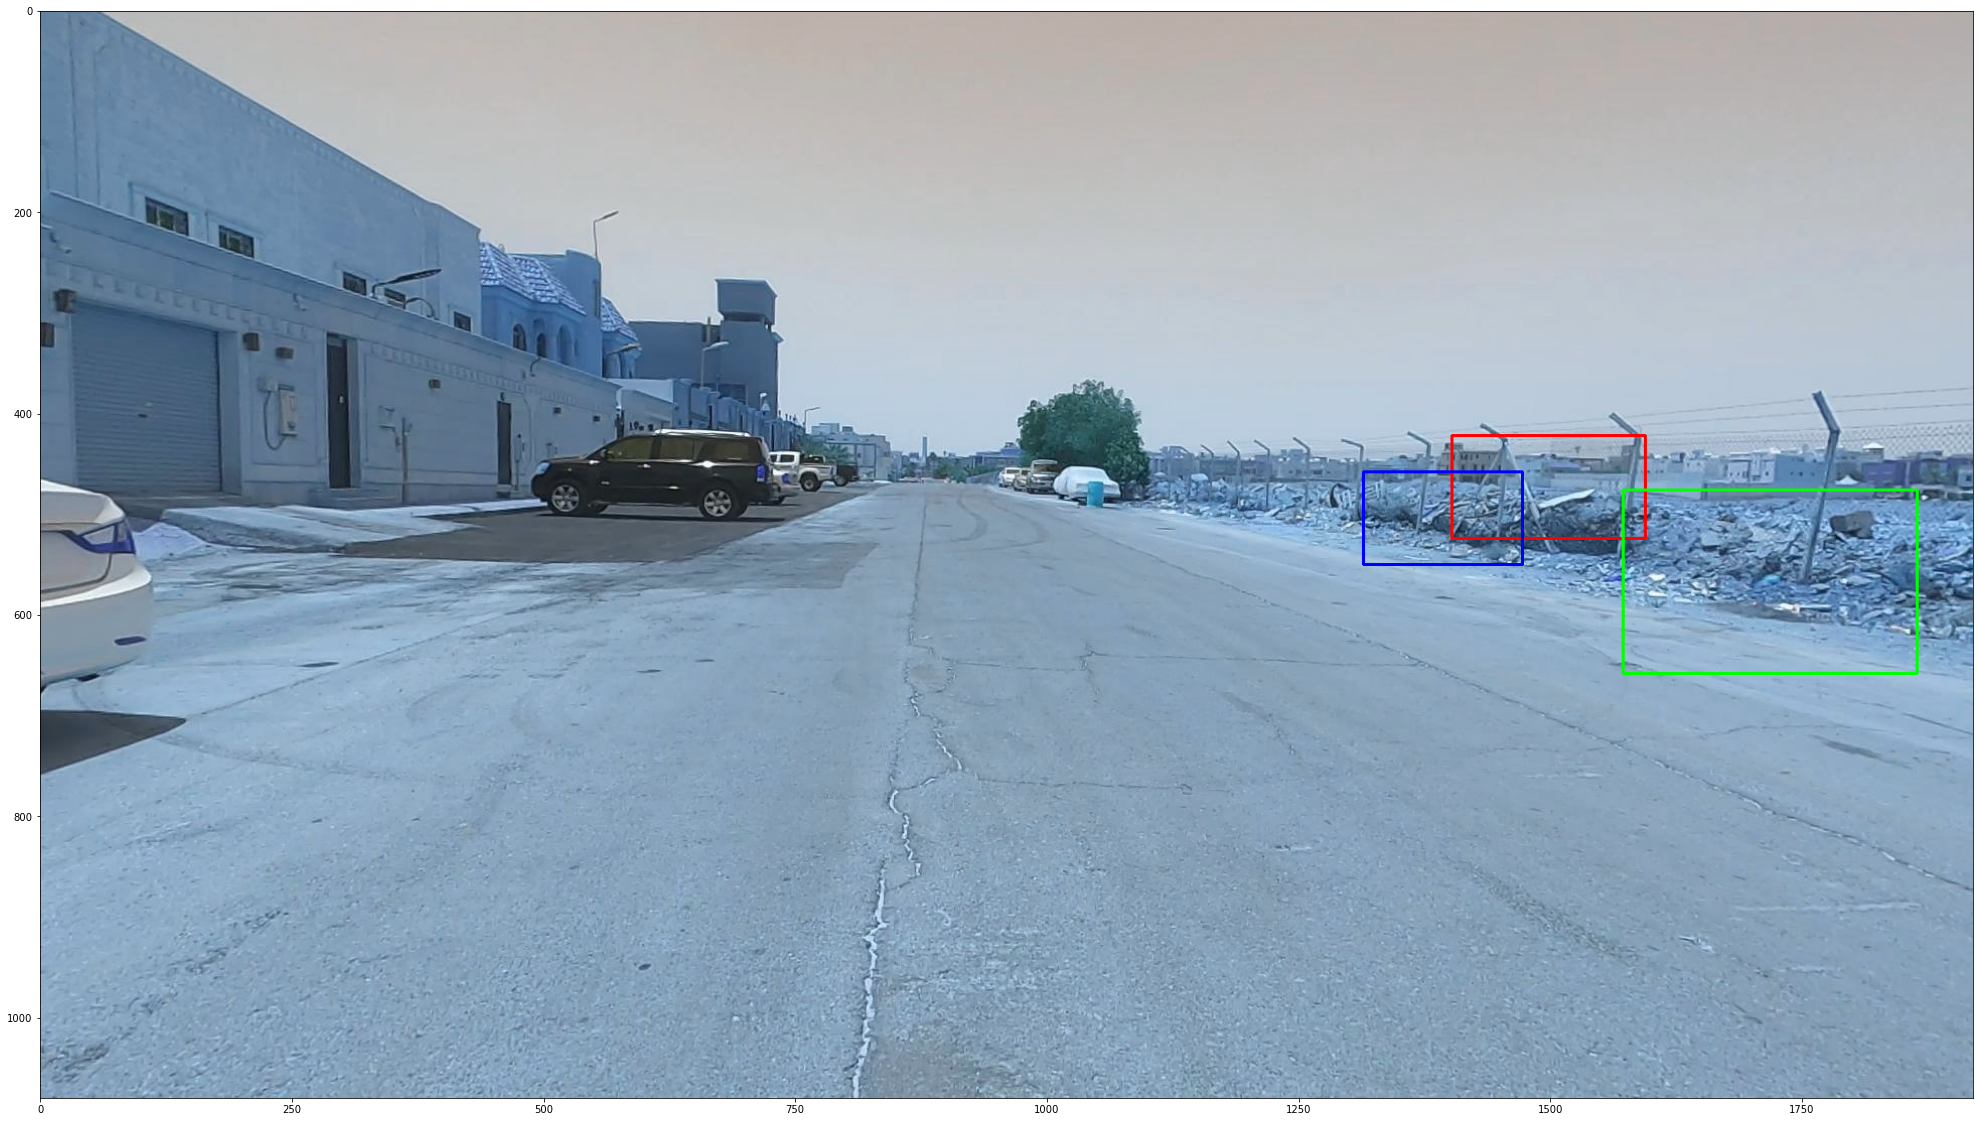

In [15]:
img = cv.imread('dataset/images/4a48c42c9579ec0399e6c5a3e825e765.jpg')
cv.rectangle(img, (int(1594), int(524)), (int(1402), int(422)), (255, 0, 0), 2)
cv.rectangle(img, (int(1864), int(658)), (int(1572), int(476)), (0, 255, 0), 2)
cv.rectangle(img, (int(1472), int(550)), (int(1314), int(458)), (0, 0, 255), 2)
plt.figure(figsize = (40,20))
plt.imshow(img);

# Create width and height columns

Note : We need these two columns for training YOLOV7 model.

In [16]:
train_df_copy['width'] = train_df_copy['xmax'] - train_df_copy['xmin']
train_df_copy['height'] = train_df_copy['ymax'] - train_df_copy['ymin']
train_df_copy.head()

,class,image_path,name,xmax,xmin,ymax,ymin,width,height
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1594.0,1402.0,524.0,422.0,192.0,102.0
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1864.0,1572.0,658.0,476.0,292.0,182.0
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1472.0,1314.0,550.0,458.0,158.0,92.0
3,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,1972.0,1572.0,272.0,2.0,400.0,270.0
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,1334.0,1098.0,456.0,358.0,236.0,98.0


# Check the categories in our problem

In [17]:
categories = train_df_copy["name"].unique()

idx = 1
for cls in categories:
    print(f'category {idx} : {cls}')
    idx += 1

category 1 : GARBAGE
category 2 : BAD_BILLBOARD
category 3 : SAND_ON_ROAD
category 4 : GRAFFITI
category 5 : POTHOLES
category 6 : CLUTTER_SIDEWALK
category 7 : CONSTRUCTION_ROAD
category 8 : BROKEN_SIGNAGE
category 9 : UNKEPT_FACADE
category 10 : FADED_SIGNAGE
category 11 : BAD_STREETLIGHT


# Check the classes and names

In [18]:
train_df_copy['class'].value_counts()

3.0     8597
4.0     2730
2.0     2625
9.0     2253
7.0     1555
0.0     1124
8.0      748
10.0     127
1.0      107
5.0       83
6.0        1
Name: class, dtype: int64

In [19]:
train_df_copy['name'].value_counts()

GARBAGE              8597
CONSTRUCTION_ROAD    2730
POTHOLES             2625
CLUTTER_SIDEWALK     2253
BAD_BILLBOARD        1555
GRAFFITI             1124
SAND_ON_ROAD          748
UNKEPT_FACADE         127
FADED_SIGNAGE         107
BROKEN_SIGNAGE         83
BAD_STREETLIGHT         1
Name: name, dtype: int64

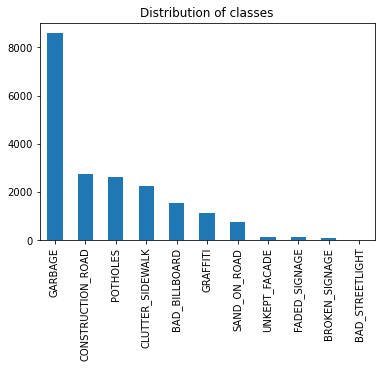

In [20]:
train_df_copy['name'].value_counts().plot(kind = 'bar')
plt.title('Distribution of classes');

# Split the training dataset into training and validation

In [21]:
train = train_df_copy[0:15960:] # 80 % of the training dataset.
valid = train_df_copy[15960::]  # 20 % of the training dataset.

In [22]:
print ("Train shape: " + str(train.shape))
print ("Valid shape: " + str(valid.shape))

Train shape: (15960, 9)
Valid shape: (3990, 9)


# Check the number of unique images in both training and validation

In [23]:
print(f'Train part contains {len(train["image_path"].unique())} unique images.')
print(f'Valid part contains {len(valid["image_path"].unique())} unique images.')

Train part contains 6344 unique images.
Valid part contains 1531 unique images.


# Build function that convert the coordinates, width and height to numbers between 0 and 1

We do this process to train our model using YOLOV7, which is require to convert the coordinates to numbers between 0 and 1.

In [24]:
def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h]

# Save the unique images and their labels in a specific folders

This process required by our YOLOV7 model, that the model need two folders (Train and Valid), and for each these two folders
there are two folders (Images and Labels), inside the Images folders, there are the images, depend on the state of that images
either a training images or the validation images, and we did the same for Labels folders, either for training or validation
there are a number of text files, each file represent an image.
inside each file, there is one or more lines, each represent the coordinates of an object, of that image.

Example :-
- Training folder
- - Images folder
- - - test_image.png
- - Labels folder
- - - test_image.txt
- - - - inside the test_image.txt : (class_number) (x_coordinates) (y_coordinate) (image_width) (image_heghit)

Note :
(class_number) (x_coordinates) (y_coordinate) (image_width) (image_heghit) are numbers between 0 and 1.

In [25]:
def save_images_labels(dataset, folder_name):
    for i in dataset['image_path'].unique():
        img_objects = dataset[dataset["image_path"] == i]
        img = cv.imread('dataset/images/' + i)
        
        with open(f'{folder_name}/Labels/{i.split(".")[0]}.txt', 'w') as f:
            for obj in img_objects.index:
                xmax = dataset['xmax'][obj]
                xmin = dataset['xmin'][obj]
                ymax = dataset['ymax'][obj]
                ymin = dataset['ymin'][obj]

                arr = pascal_voc_to_yolo(xmin, ymin, xmax, ymax, img.shape[1], img.shape[0])
                x, y, w, h = arr[0], arr[1], arr[2], arr[3]

                if x < 0:
                    x = 0
                elif x > 1:
                    x = 1
                if y < 0:
                    y = 0
                elif y > 1:
                    y = 1
                if w < 0:
                    w = 0
                elif w > 1:
                    w = 1
                if h < 0:
                    h = 0
                elif h > 1:
                    h = 1
                
                f.write(f'{int(train["class"][obj])} {x} {y} {w} {h}')
                
                if obj != len(img_objects.index) - 1:
                    f.write(f'\n')
            f.close()
            position = fr'{folder_name}/Images/{i}'
            cv.imwrite(position, img)

The cell below not neccassory to run, it is for saving the images and labels in our local computer.

In [ ]:
save_images_labels(train, 'Train')
save_images_labels(valid.reset_index().drop(columns = 'index'), 'Valid')

The code below is response to check the number of images and files, if they equal to what we acpect (e.q : if the images == the unique images).

In [26]:
counter = 0
for path in os.listdir('Train/Labels/'):
    if (path.endswith(".txt")):
        with open(f'Train/Labels/{path}', 'r') as f:
            for i in f.readlines():
                arr = i.split(' ')
                #print(arr)
                if float(arr[1]) < 0 or float(arr[1]) > 1:
                    counter += 1
                if float(arr[2]) < 0 or float(arr[2]) > 1:
                    counter += 1
                if float(arr[3]) < 0 or float(arr[3]) > 1:
                    counter += 1
                if float(arr[4]) < 0 or float(arr[4]) > 1:
                    counter += 1
print(counter)

counter = 0
for path in os.listdir('Valid/Labels/'):
    if (path.endswith(".txt")):
        with open(f'Valid/Labels/{path}', 'r') as f:
            for i in f.readlines():
                arr = i.split(' ')
                #print(arr)
                if float(arr[1]) < 0 or float(arr[1]) > 1:
                    counter += 1
                if float(arr[2]) < 0 or float(arr[2]) > 1:
                    counter += 1
                if float(arr[3]) < 0 or float(arr[3]) > 1:
                    counter += 1
                if float(arr[4]) < 0 or float(arr[4]) > 1:
                    counter += 1
print(counter)

0
0


# Check if the images and labels inside Train and Valid folders

In [27]:
imgs = 0
txts = 0
for path in os.listdir('Train/images/'):
    if (path.endswith(".jpg")):
        imgs += 1
for path in os.listdir('Train/Labels/'):
    if (path.endswith(".txt")):
        txts += 1
            
print(len(train['image_path'].unique()), txts)
print(len(train['image_path'].unique()), imgs)

6344 6344
6344 6344


In [28]:
imgs = 0
txts = 0
for path in os.listdir('Valid/Images/'):
    if (path.endswith(".jpg")):
        imgs += 1
for path in os.listdir('Valid/Labels/'):
    if (path.endswith(".txt")):
        txts += 1
            
print(len(valid['image_path'].unique()), txts)
print(len(valid['image_path'].unique()), imgs)

1531 1531
1531 1531


# Train YOLOV7 model by using our cleaned dataset (Train and Valid folders)

###### Note: Training and testing need powefull preformance and it is not needed for you, because we already built model

In [ ]:
!python train.py --weights yolov7-e6e.pt --data "data/coco.yaml" --workers 4 --device 0 --batch-size 32 --img 416 --cfg cfg\training\yolov7.yaml --name yolov7 --hyp data/hyp.scratch.p5.yaml --epochs 100

In [ ]:
!python test.py --data data/coco.yaml --workers 4 --device 0 --batch-size 32 --img 416 --weights runs/train/yolov7/weights/yolov7-e6e.pt --cfg cfg\training --name yolov7 --hyp data/hyp.scratch.p5.yaml

# Load the model to detect test images

In [ ]:
from hubconf import custom

model = custom(path_or_model='yolov7/best.pt')

test_df.head()

In [ ]:
class_dict = {
    0: "GRAFFITI",
    1: "FADED_SIGNAGE",
    2: "POTHOLES",
    3: "GARBAGE",
    4: "CONSTRUCTION_ROAD",
    5: "BROKEN_SIGNAGE",
    6: "BAD_STREETLIGHT",
    7: "BAD_BILLBOARD",
    8: "SAND_ON_ROAD",
    9: "CLUTTER_SIDEWALK",
    10: "UNKEPT_FACADE"
}

submission_df = pd.DataFrame(columns = ["class", "image_path", "name", "xmax", "xmin", "ymax", "ymin"])


counter = 0
for filename in tqdm(df["image_path"].unique()):
    img = cv.imread("yolov7/images/" + filename)
    acc = model(img)

    pred = acc.pred[0].numpy()
    if len(pred) != 0:
      for e_pred in pred:
        xmin, ymin, xmax, ymax, accuracy, class_nu = e_pred
        submission_df.loc[counter] = [class_nu, filename, class_dict[class_nu], xmax, xmin, ymax, ymin]
        counter += 1
    else:
        submission_df.loc[counter] = [None, None, None, None, None, None, None]

submission_df.head()

# Save Result File

In [ ]:
submission_df.to_csv("Result.csv", index=False)